In [1]:
import numpy as np
from numpy import median
import seaborn as sns
import pandas as pd
import scipy.stats as ss
from scipy import signal 
import cPickle as pickle
from lab.classes.dbclasses import dbMouse
from scipy.ndimage.interpolation import shift
import itertools as it
import matplotlib.pyplot as plt
from lab.analysis import behavior_analysis as ba
from pandas import read_excel
from scipy.signal import resample as rs
from scipy.ndimage import gaussian_filter1d as gauss
from lab.analysis.imaging_analysis import offsetPCA
from matplotlib.colors import LogNorm

In [2]:
with open('Peri_Ripple_Traces_3s_Window_All_Mice.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data = data[data.Region != 'CA1']
data = data.replace(to_replace = 'Bistr', value = 'SOM')
data = data.replace(to_replace = 'SOM/CB', value = 'SOM')
data = data.replace(to_replace = 'CA2/CA3', value = 'CA3')
data = data[data.Region == 'CA3']
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
data = data[data.Subtype.isin(subtypes)]

/home/tristan/.local/lib/python2.7/site-packages/pandas/core/missing.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [4]:
data.loc[(data.Subtype == 'CB') & (data.SATB1 == '+'), 'Subtype'] = 'CB/SATB1+'
data.loc[(data.Subtype == 'CB') & (data.SATB1 == '-'), 'Subtype'] = 'CB/SATB1-'

In [5]:
df = []
for sbt in ['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']:
    sub = data[data.Subtype == sbt]['Avg_Trace']
    for i in range(len(sub)):
        trace = signal.savgol_filter(rs(sub.iloc[i], 600), 21, 7)
        base = np.mean(trace[10:100])
        pos_mod = np.max(trace[200:400]) - base
        neg_mod = np.abs(np.min(trace[200:400])) - base
        if pos_mod > neg_mod:
            sign = 1
            mod = pos_mod
        else:
            sign = -1
            mod = neg_mod
        df.append({'subtype': sbt, 'modulation': sign * mod, 'trace': trace})
df = pd.DataFrame(df)

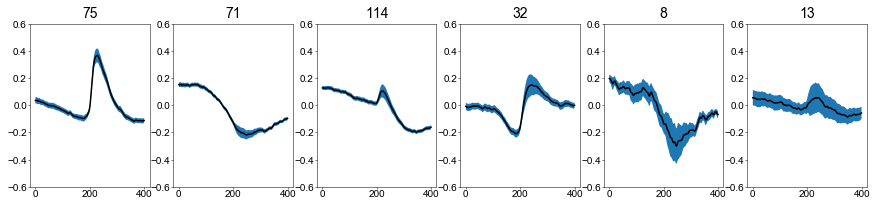

In [60]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for iax, sbt in enumerate(['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']):
    sub = df[(df.subtype == sbt)]['trace']
    trace_all = []
    for i in range(len(sub)):
        trace = signal.savgol_filter(rs(sub.iloc[i], 600), 21, 7)
        trace_all.append(trace[100:500])
    avg = np.nanmean(trace_all, axis=0); sem = ss.sem(trace_all, axis=0)
    axs[iax].plot(avg, 'k')
    axs[iax].fill_between(range(len(avg)), avg-sem, avg+sem)
    axs[iax].set_ylim(-0.6, 0.6); 
    axs[iax].set_title(len(trace_all), fontsize=14)
    plt.savefig('ALL_CA3.eps')

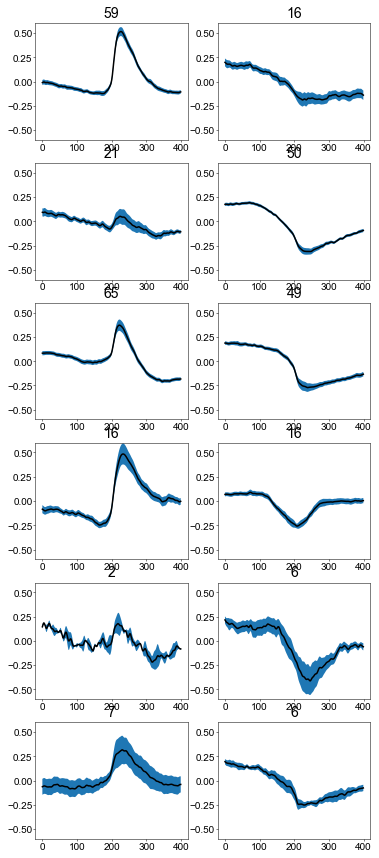

In [35]:
fig, axs = plt.subplots(6, 2, figsize=(6, 15))
for iax, sbt in enumerate(['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']):
    sub = df[(df.subtype == sbt) & (df.modulation >0)]['trace']
    trace_all = []
    for i in range(len(sub)):
        trace = signal.savgol_filter(rs(sub.iloc[i], 600), 21, 7)
        trace_all.append(trace[100:500])
    avg = np.nanmean(trace_all, axis=0); sem = ss.sem(trace_all, axis=0)
    axs[iax,0].plot(avg, 'k')
    axs[iax,0].fill_between(range(len(avg)), avg-sem, avg+sem)
    axs[iax,0].set_ylim(-0.6, 0.6); 
    axs[iax,0].set_title(len(trace_all), fontsize=14)

for iax, sbt in enumerate(['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']):
    sub = df[(df.subtype == sbt) & (df.modulation <= 0)]['trace']
    trace_all = []
    for i in range(len(sub)):
        trace = signal.savgol_filter(rs(sub.iloc[i], 600), 21, 7)
        trace_all.append(trace[100:500])
    avg = np.nanmean(trace_all, axis=0); sem = ss.sem(trace_all, axis=0)
    axs[iax,1].plot(avg, 'k')
    axs[iax,1].fill_between(range(len(avg)), avg-sem, avg+sem)
    axs[iax,1].set_ylim(-0.6, 0.6); 
    axs[iax,1].set_title(len(trace_all), fontsize=14)
# plt.savefig('SWR_waveform_CA3.eps')

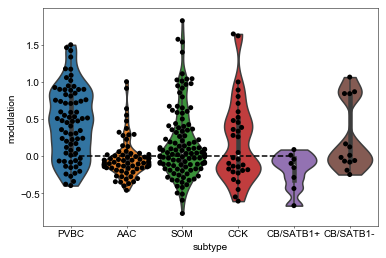

In [22]:
fig, axs = plt.subplots(1, 1)
sns.violinplot(x='subtype', y='modulation', data=df, width = .8, cut =0, scale='width', bw=.25)

sns.swarmplot(x='subtype', y='modulation', data=df, palette=['k'])
axs.plot([0, 4], [0, 0], 'k--')
plt.savefig('Violin_Modulation_CA3.eps')

In [19]:
df[df.subtype == 'CB/SATB1-']['modulation'].to_csv('test.csv')

/home/tristan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
'CB/SATB1+', 'CB/SATB1-'

In [13]:
df.to_csv??

Signature: df.to_csv(path_or_buf=None, sep=',', na_rep='', float_format=None, columns=None, header=True, index=True, index_label=None, mode='w', encoding=None, compression='infer', quoting=None, quotechar='"', line_terminator=None, chunksize=None, tupleize_cols=None, date_format=None, doublequote=True, escapechar=None, decimal='.')
Source:   
    def to_csv(self, path_or_buf=None, sep=",", na_rep='', float_format=None,
               columns=None, header=True, index=True, index_label=None,
               mode='w', encoding=None, compression='infer', quoting=None,
               quotechar='"', line_terminator=None, chunksize=None,
               tupleize_cols=None, date_format=None, doublequote=True,
               escapechar=None, decimal='.'):
        r"""
        Write object to a comma-separated values (csv) file.

        .. versionchanged:: 0.24.0
            The order of arguments for Series was changed.

        Parameters
        ----------
        path_or_buf : str or file han

In [7]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [24]:
lm = ols('modulation ~ subtype', data = df).fit()

In [25]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
subtype,5.0,10.026278,2.005256,10.04,6.484090e-09
Residual,307.0,61.316088,0.199727,NaN,NaN


In [47]:
ss.kruskal(df[df.subtype=='PVBC']['modulation'], df[df.subtype=='AAC']['modulation'], 
           df[df.subtype=='SOM']['modulation'], df[df.subtype=='CCK']['modulation'],
          df[df.subtype=='CB/SATB1+']['modulation'], df[df.subtype=='CB/SATB1-']['modulation'])

KruskalResult(statistic=45.60961680825528, pvalue=1.0905408225996618e-08)

In [52]:
mc = MultiComparison(df['modulation'], df['subtype'])
result1 = mc.tukeyhsd()
result2 = mc.allpairtest(ss.mannwhitneyu)

In [55]:
result2[0]

group1,group2,stat,pval,pval_corr,reject
AAC,CB/SATB1+,223.0,0.1628,1.0,False
AAC,CB/SATB1-,288.0,0.0162,0.2429,False
AAC,CCK,929.0,0.0706,1.0,False
AAC,PVBC,1050.0,0.0,0.0,True
AAC,SOM,2846.0,0.0004,0.0053,True
CB/SATB1+,CB/SATB1-,23.0,0.0195,0.2926,False
CB/SATB1+,CCK,79.0,0.0505,0.7577,False
CB/SATB1+,PVBC,78.0,0.0003,0.0047,True
CB/SATB1+,SOM,242.0,0.0136,0.2042,False
CB/SATB1-,CCK,182.0,0.2616,1.0,False


In [39]:
for iax, sbt in enumerate(['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']):
    print(sbt), ss.wilcoxon(df[df.subtype==sbt]['modulation'])[1]

PVBC 1.1780617826953488e-09
AAC 0.0046469659309327106
SOM 0.0060697913479679485
CCK 0.1119678847881897
CB/SATB1+ 0.0687035743228782
CB/SATB1- 0.31089682851661204


In [34]:
for iax, sbt in enumerate(['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']):
    print(sbt), (np.mean(df[df.subtype==sbt]['modulation']), np.std(df[df.subtype==sbt]['modulation']))

PVBC (0.45117856515884813, 0.47559242237122057)
AAC (-0.03688320305136615, 0.2713377539755766)
SOM (0.17388420387537493, 0.47711673581033553)
CCK (0.20519938145903366, 0.55956777999687)
CB/SATB1+ (-0.19396428080829092, 0.2441394477568068)
CB/SATB1- (0.24488031657556542, 0.45379669252025134)


In [56]:
for iax, sbt in enumerate(['PVBC', 'AAC', 'SOM', 'CCK', 'CB/SATB1+', 'CB/SATB1-']):
    print(sbt), len(df[df.subtype==sbt]['modulation'])

PVBC 75
AAC 71
SOM 114
CCK 32
CB/SATB1+ 8
CB/SATB1- 13


In [24]:
ss.ttest_ind(df[df.subtype=='AAC']['modulation'], df[df.subtype=='PVBC']['modulation'])

Ttest_indResult(statistic=-3.3882207569262883, pvalue=0.0010453528485470202)

In [23]:
from sklearn.decomposition import PCA

In [31]:
clf = PCA(n_components=2)
pca = clf.fit_transform(np.nan_to_num(np.vstack(df['trace'])))
# pc1 = pca.components_[0,:]; pc2 = pca.components_[1,:]

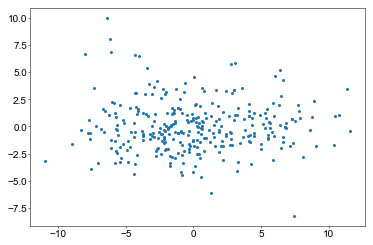

In [33]:
for i, col in enumerate(df, )
    print(sbt), ss.ttest_1samp(df[df.subtype==sbt]['modulation'], 0)
    
plt.plot(pca[:,0], pca[:, 1], 'o')

In [136]:
def centroid(pf):
    avg = np.mean(pf)
    p = np.argmin(np.abs(pf - avg))
    return np.asarray(p)

In [137]:
df2=[]
for ii in range(len(df)):
    sbt = df.iloc[ii].subtype
    tt = signal.savgol_filter(np.sign(df.iloc[ii].modulation) * df.iloc[ii].trace, 51, 3)
    tt = tt - np.min(tt)
    c = centroid(tt)
    if df.iloc[ii].modulation < 0:
        mod = 'neg'
    else:
        mod = 'pos'
    df2.append({'subtype': sbt, 'centroid': c - 300, 'modType': mod})
    
df2=pd.DataFrame(df2)

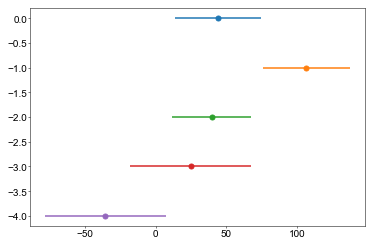

In [139]:
count = 0
for sbt, modT in zip(['PVBC', 'AAC', 'SOM', 'CCK', 'CB'], ['pos', 'neg', 'neg', 'neg', 'pos']):
    values = df2[(df2.subtype == sbt) & (df2.modType == modT)]['centroid'].values
    avg = np.nanmean(values); sem = ss.sem(values)
    plt.errorbar(avg, count, xerr=sem, marker='.', markersize=10)
    count = count - 1